<a href="https://colab.research.google.com/github/drAshcroft/ProteinConduct/blob/main/PathsKMC2_CTPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading PDB file... ./CTPRFixed4.pdb
dx file found
Found Injection Node 0
Found Exit Node 12
A has 68 amino acids with 14 redox cofactors
Find ChargeFile at ./CTPRFixed4.charge
Found charge file: ./CTPRFixed4.charge
Find vibrations at ./CTPRFixed4.std
Found std file: ./CTPRFixed4.std


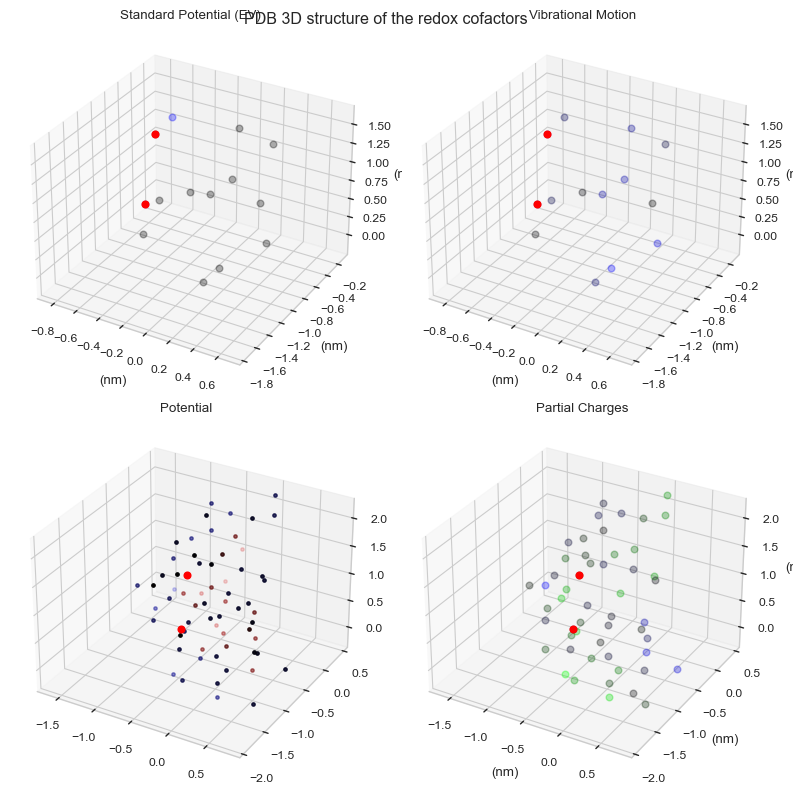

In [ ]:
#!pip install biopython
#!pip install networkx
#!pip install seaborn
#!pip install griddataformats

import numpy as np
import KMC_Protein
from KMC_Protein import hbar_eV, kbT_eV
from numpy import random
rng= random.default_rng()
import matplotlib.pyplot as plt
import os
import numpy as np
import networkx as nx
import seaborn as sns
import KMC_Plotting



sns.set_style("whitegrid")
sns.set_context("paper")

pdb_file = r'./CTPRFixed4.pdb'


#comment out the following line if amino is not desired.
redoxEnergies = {'TRP': .85,
                 'TYR': 1.08, #1.08,
                 #'PHE': 1.15,  #  This is just a guess value from a few papers (Charge Transfer in Model Peptides: Obtaining Marcus Parameters from Molecular Simulation)
                 'CYS': .85, #1.12,
                 #'HIS': 1.31,
                 #'MET': 1.43,
                 #'BTN': 1.03
                 }  # https://iopscience.iop.org/article/10.1149/2.1471714jes

maxInteraction_radius_nm = 1.6  # nm   this will be used to determine neighbors of each redox cofactor

vibrationRadius_nm = .2  # nm this is a global value for the radius of the vibration sphere of the amino acid, only used if there is not an .std file for this protein

dutton_radius_nm = 1.35 # nm maximum distance between the redox cofactor that allows for electron transfer

reorgE_EV=.2  #standard reorganization energy in eV

injectionAminos = [{'residue':'TRP', 'model':0, 'chain':'A', 'index':35} ]

exitAminos  =  [{'residue':'TYR', 'model':0, 'chain':'A', 'index':88} ]

appliedVoltage_V = .2 #V  #assumed to be the voltage at the electrodes

attemptFrequency = 2*np.pi/hbar_eV/np.sqrt( 4*np.pi*reorgE_EV*kbT_eV  )   # attempt prefactor 2 pi/ hbar
beta = 1/(kbT_eV)  # 1/kT in 1/eV

print('Loading PDB file...', pdb_file)

#estimate the center of mass for each amino acid
atom_COM,activeAminos = KMC_Protein.LoadAminoCenterOfMass(pdb_file, redoxEnergies,injectionAminos,exitAminos, verbose=True )

KMC_Plotting.PlotPDBProjections(activeAminos,atom_COM,injectionAminos,exitAminos)

## CTPR 4

We are showing the center of mass of all the redox active residues in the CTPR molecule to allow comparison with the published values in
[Long-Range Conductivity in Proteins Mediated by Aromatic Residues](https://pubs.acs.org/doi/10.1021/acsphyschemau.3c00017)

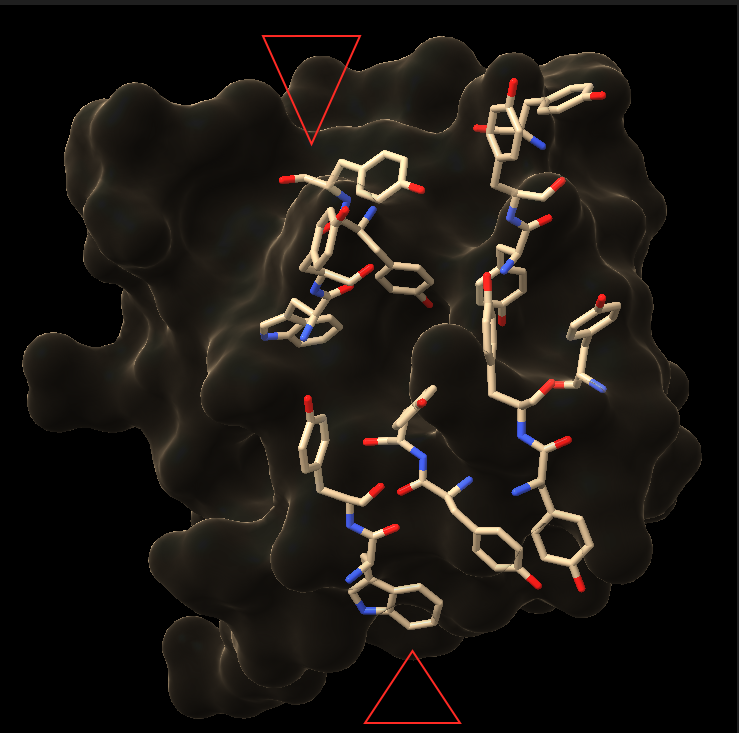

## CTPR4

  We are looking at the conductivity of this constructed protein, The electron is inserted into the structure at the base of the two streptavidins at the Amino acid location marked by red
The above graphs show the various parameters that have been calcuted about this protein structure from other tools.  

### Standard Potential

The redox factors are taken from literature and assumed to be unaltered by the protein environment.

### Potentials

 Potentials have been calcuated from [Adaptive Poisson-Boltzmann Solver ](https://server.poissonboltzmann.org/)  -  [literature](https://pubmed.ncbi.nlm.nih.gov/28836357/)

### Vibrational Motion

 The Vibrational Motion has been determined by running CG simulations in [CafeMol](https://www.cafemol.org/)  -   [literature](https://pubs.acs.org/doi/full/10.1021/ct2001045) using beads on a chain with charges derived from the RESPAC

### Partial Charges

 Partial charges of the chain as estimated by APBS and the [RESPAC](https://pubs.acs.org/doi/full/10.1021/ct4007162) method


Driving force for electron transfer in molecule is 0.01 V/nm
Potentials mapped
Embedding Found
Total pot (eV) 0.008556954891164389 -0.09922570019094072
charges (e) 2.1155 -1.9152
Smoothing Energy Map


d:\PythonProj\KineticMontiCarlo\KMC_Plotting.py:228: RuntimeWarning: divide by zero encountered in log10
  vibrateStruct = np.max(np.log10( vibrationPoints))/np.max(vibrateStruct)*vibrateStruct


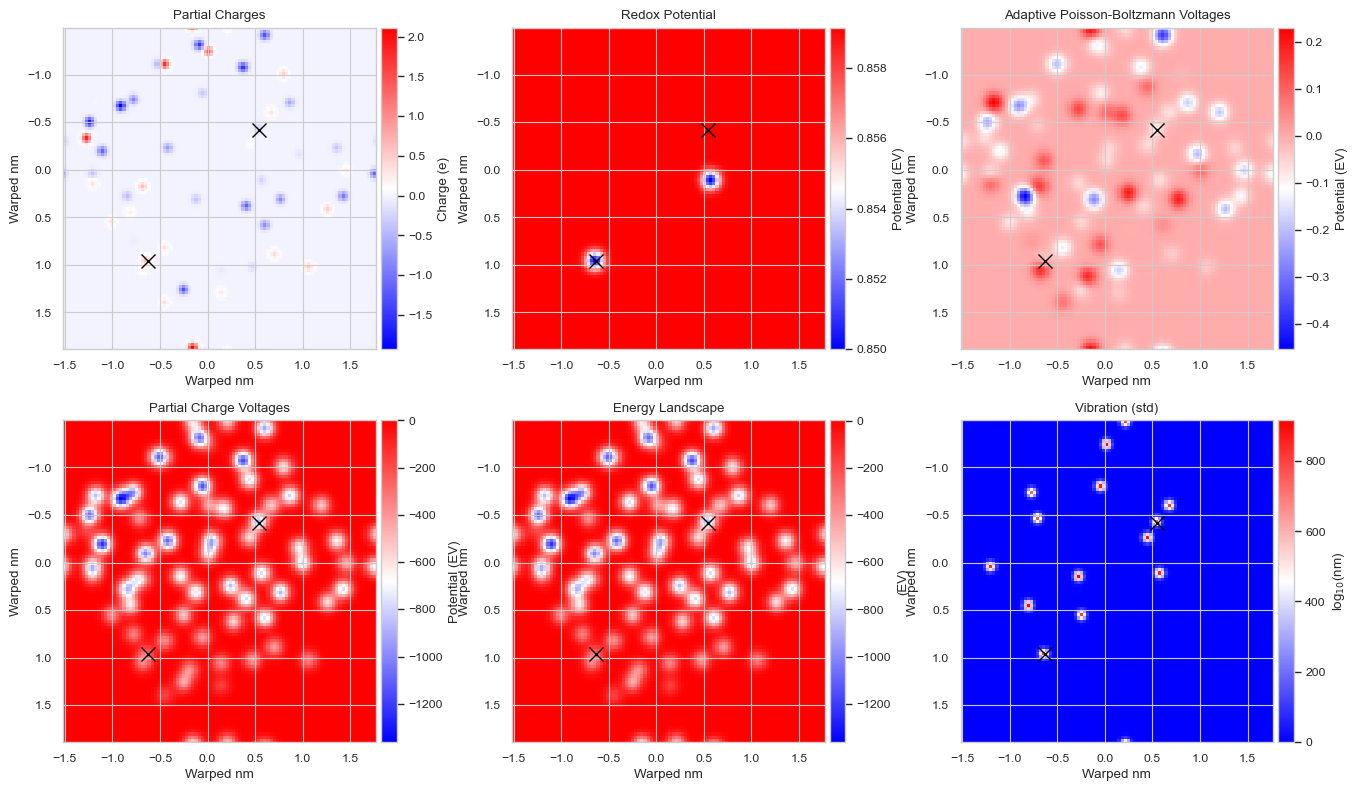

In [ ]:
field, fieldZero =KMC_Protein. CalculatePotentials(atom_COM,activeAminos,injectionAminos[0],exitAminos[0],appliedVoltage_V, verbose =True)
KMC_Plotting.CreateProteinManifold(atom_COM, verbose=True)

KMC_Plotting.PlotPotentialMap(atom_COM )

### Manifold graphs

3D structure of the protein complex was reduced to 2D using a manifold esimate to allow easier viewing of the energy landscape.  Most of the relationships between the different redox cofactors have been preserved.  The inject and removal points have been marked with X allowing visualization of pathways that may form.

### Estimation of the driving bias

We consider the self potential of the protein as derived from the CHARMM force field through the APBS program.  The induced charges are then added to give the potential from the charged amino acids inside the protein.  Finally, the redox potentials of the various amino acids are added to the landscape.

The driving bias from the applied voltage is approximated by using this graph (CTPR supplimental )[https://pubs.acs.org/doi/suppl/10.1021/acsphyschemau.3c00017/suppl_file/pg3c00017_si_001.pdf]

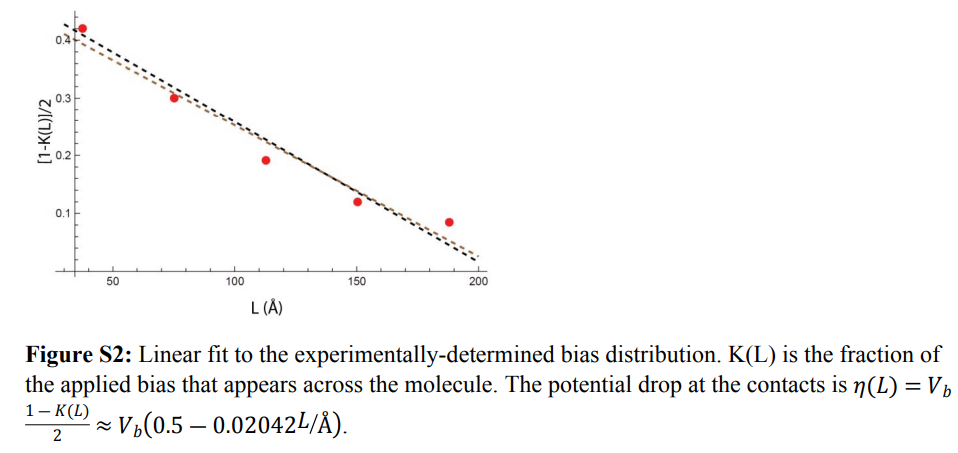

min neighbors: 12
max neighbors: 26
mean neighbors: 19.714285714285715
scale metric of graph: 57848.0
local bridges: 0
std neighbors: 3.98978286964827
number of redox cofactors: 14
number of tunnel gaps: 138


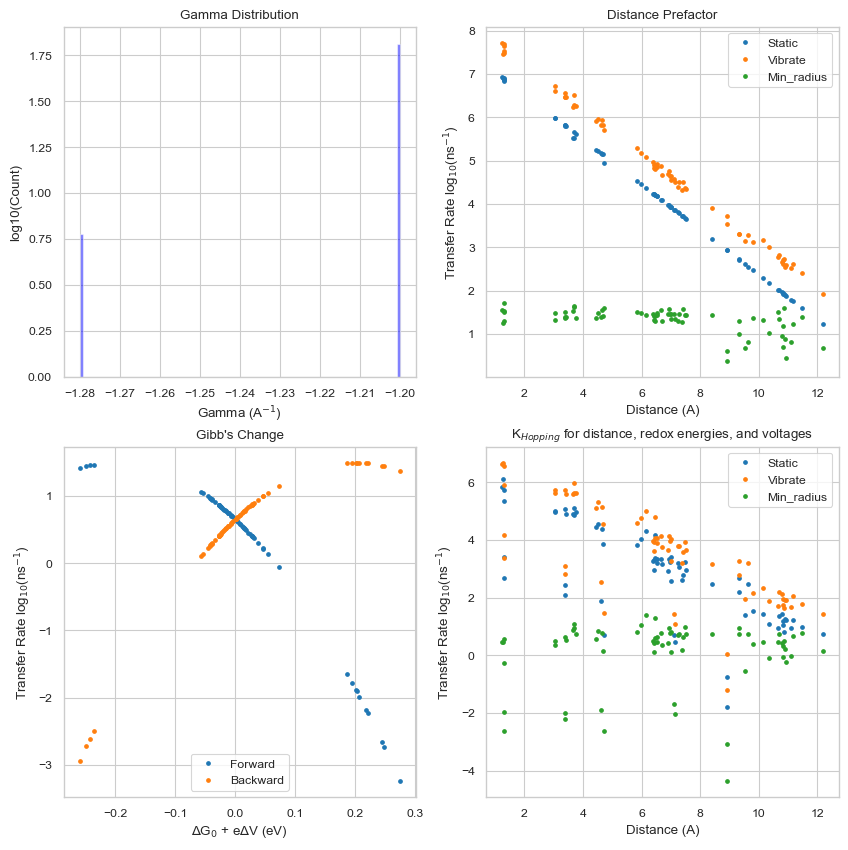

In [ ]:
##################################################################################################
#                 Determine the transfer rates for each redox cofactor pair
#
##################################################################################################
G_static, G_vibrate, G_min, G_connected, plotValues =KMC_Protein. ConnectGraphs(activeAminos, atom_COM,reorgE_EV, beta,maxInteraction_radius_nm,
                                                                                attemptFrequency, vibrationRadius_nm,dutton_radius_nm, verbose=True )

(gammas, distanceRates, energyRates, transferRates, voltageRates)=plotValues
KMC_Plotting.PlotGraphRates(gammas, distanceRates, energyRates, transferRates, voltageRates)
#del plotValues, gammas, distanceRates, energyRates, transferRates, voltageRates


## Rate Calculations
We are assuming that the jumps performed between each redox cofact can be modeled by Marcus theory with each jump modeled by the following equation

$k_{et} = \frac{2\pi}{\hbar}| H_{AB} |^2\frac{1}{\sqrt{ 4 \pi \lambda k_B T }} \exp(- \frac {\Delta G^{\dagger}} {k_B T} )  $

where

$\Delta G^{\dagger} = \frac{(\lambda + \Delta G^{\circ} + e\Delta V)^2}{4 \lambda k_B T}$ as shown in the Gibb's change in the graph above. As we do not have precise calculations of $\Delta G^{\circ}$, the redox standard potentials are used

from [Long-range electron transfer](https://www.pnas.org/doi/10.1073/pnas.0408029102) and [Theory and Electrochemistry of Cytochrome c](https://pubs.acs.org/doi/10.1021/acs.jpcb.7b00917) we can model the complicated action of the electron transfering to the next redox cofactor with a simplified form for the distance dependance of

$ | H_{AB} | \propto exp ( - \frac { \gamma (p)} {2} R) $

where $p$ is the percent of protein media between the redox cofactors as shown in the distance prefactor graph.







## Gamma calculations

The tunnel time between redox cofactors is strongly dependant on which media carries the electron as show in the graph from [Long-range electron transfer](https://www.pnas.org/doi/10.1073/pnas.0408029102)

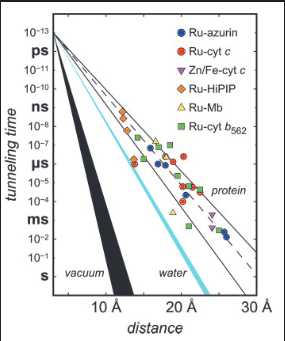

While most proteins are solid, this construct has a number of jumps that travel through the water environment.  In order to deal with the different media, the path that the electron travels is examined to determine whether it moves through protein media or through the water environment.

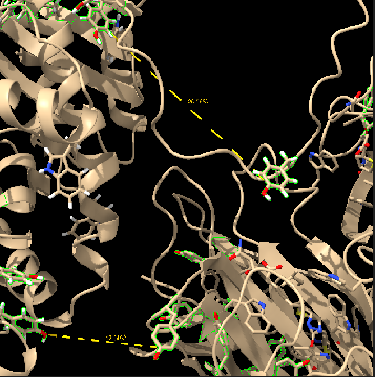

Image showing the jumps from one Tyrosine to the next and the path the electrode must travel.  The gamma for each pair of neighbors is estimated to allow rate calculations to be adjusted.

## Min network

We do not have the full power of an all atom simulation of the protein.  Instead the distance rate parameter is estimated by mimicing the values (published )[https://pubs.acs.org/doi/10.1021/acsomega.3c02719].  We select an interaction radius, and then limit the rates at that value.  As can be seen in the figure above (Distance Prefactor graph), we are able to largely mimic the given values

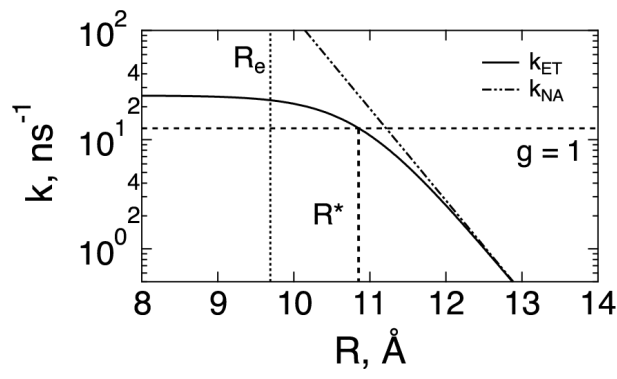


## Static network

The values estimated from the PBS are used with Marcus theory to give jumps between the redox cofactors.



## Vibrate network

We are assuming that the jumps performed between each redox cofact can be modeled by Marcus theory with each jump modeled by the following equation

$k_{et} = \frac{2\pi}{\hbar}| H_{AB} |^2\frac{1}{\sqrt{ 4 \pi \lambda k_B T }} \exp(- \frac {\Delta G^{\dagger}} {k_B T} )  $

where

$\Delta G^{\dagger} = \frac{(\lambda + \Delta G^{\circ} + e\Delta V)^2}{4 \lambda k_B T}$ as shown in the Gibb's change in the graph above

from [Long-range electron transfer](https://www.pnas.org/doi/10.1073/pnas.0408029102) and (Theory and Electrochemistry of Cytochrome c)[https://pubs.acs.org/doi/10.1021/acs.jpcb.7b00917] we can model the complicated action of the electron transfering to the next redox cofactor with a simplified form for the distance dependance of

$ | H_{AB} |^2 \propto exp ( - \gamma(p) R) exp( \frac {1}{2} \gamma^2<(\delta R)^2>  ) $

where $p$ is the percent of protein media between the redox cofactors as shown in the distance prefactor graph.

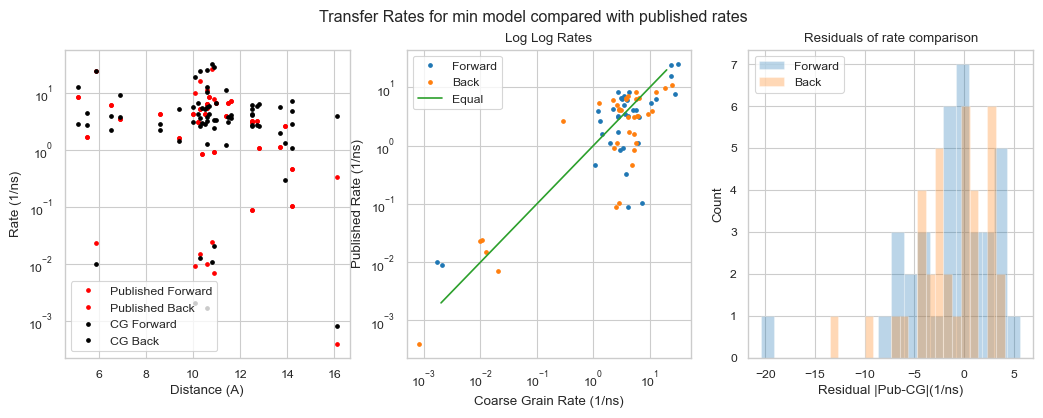

MAE forward:3.21e+00 1/ns
MAE back:2.93e+00 1/ns
MAE all:3.07e+00 1/ns


In [ ]:
KMC_Plotting. CompareWithPublished(activeAminos,G_min,transferRates)

Comparing the rates predicted by the model with rates published in the suppliment of [Long-Range Conductivity in Proteins Mediated by Aromatic Residues](https://pubs.acs.org/doi/suppl/10.1021/acsphyschemau.3c00017/suppl_file/pg3c00017_si_001.pdf)

The CG rates have a mean absolute error of ~3.07 ns from the published all atom rates, and are largely randomly distributed around the line.  Most of the values that fall significantly away from the line are related to TRP 69, TYR 48, which seem to be more suseptible to the distrubances on the water/protein interface.

The min model is expected to give the closest results to those published in the paper due to the slower transfer rates than those calculated from simple distance measurements

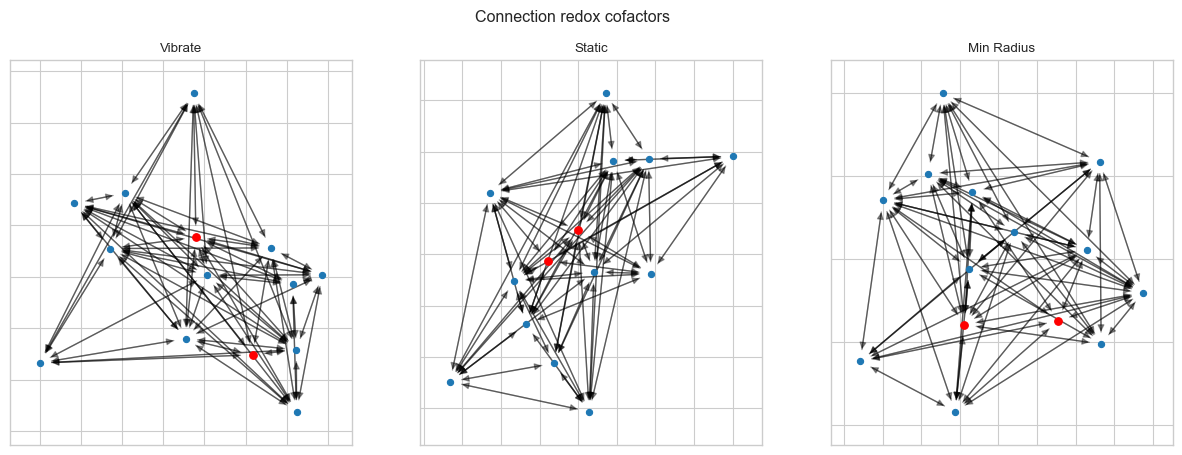

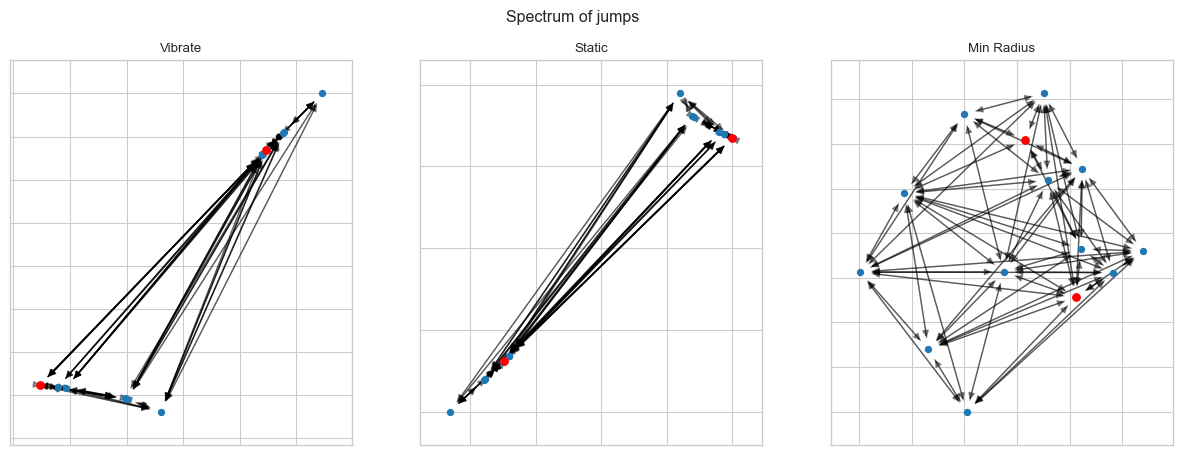

In [ ]:
##################################################################################
#################      Network Visualizations         ############################
##################################################################################


if True:
    graphs = [['Vibrate',G_vibrate],['Static', G_static],['Min Radius', G_min]]
    KMC_Plotting.DrawLayout(graphs, lambda G: nx.spring_layout(G,weight='time'), 'Connection redox cofactors', injectionAminos, exitAminos, False)
    #DrawLayout(graphs, lambda G: nx.spectral_layout(G,weight='time'), 'Spectrum of redox cofactors')
    KMC_Plotting.DrawLayout(graphs, lambda G: nx.kamada_kawai_layout(G,weight='time'), 'Spectrum of jumps', injectionAminos, exitAminos, False )


### Node maps.

Node maps abandon the euclidean geometry completely to form networks based on the nfearest neighbor connections and the transfer times between the redox cofactors. The networks indicate that while we do have error in the various jumps, the overal random nature of the errors and the large number of interconnections between the aromatic amino acids largely cancel out to give an average value of tranferance that should match with the higher resolution all atom calculations.  This is not true for the Phi29  calculations where there are single amino acids that handle almost all the current that is transfered

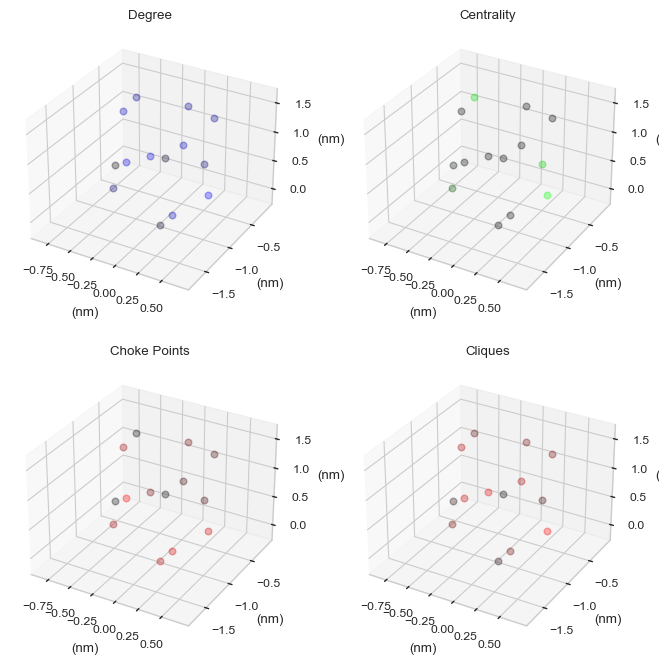

In [ ]:
##################################################################################
#################      Network Analysis 2             ############################
##################################################################################

popularity= KMC_Plotting. PlotNetworkMetrics(G_connected, activeAminos)

## Network analysis

These graphs are related only the the network of neighbors formed from these proteins.  The graphs are designed to identify properties of the networks and identify those cofactors that are uniquely connected to make them important for the proteins.

### Clusters

Idenify possible number of triangles through each point, allowing for communication with that node

### Choke Points

Between centrality finds all the shortest paths between all the pairs of nodes in the graph.  Those nodes that participate in the most paths, are those that are likely to be the most important for conductivity.  Those nodes that do not have many parallel paths are likely to be choke points and determine the conductivity of the whole construct. (wiki)[https://en.wikipedia.org/wiki/Betweenness_centrality]

### Cliques

Cliques of a graph are subgraphs where any two members of a clique share a vertex.  By overlaying the cliques and adding a count to a node for each overlap, we can identify those nodes that participate most in the communication through the network and are ikely important for conduction. (wiki)[https://en.wikipedia.org/wiki/Clique_(graph_theory)]



Total paths tested:  50
The average tunnel distance is 0.41 nm
All paths must make at least one jump >= 0.61 nm jump


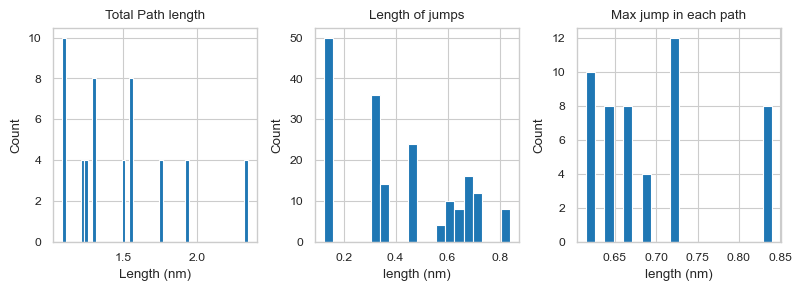

In [ ]:
def CalculateDistancePaths(useMinimum=True):
    if useMinimum:
        weight='minDist'
    else:
        weight='distance'
    shortestPaths_connected=[]

    for startNode in [amino['aminoIndex'] for amino in injectionAminos]:
        for endNode in [amino['aminoIndex'] for amino in exitAminos]:
            shortestPaths_connected.extend( KMC_Protein. CalculatePaths(G_connected, activeAminos  ,startNode,endNode, weight=weight ))
    KMC_Plotting. PlotDistancePaths(G_connected, shortestPaths_connected, weight)

CalculateDistancePaths()

## Path lengths

We do a quick check to see what the greatest jump is that the electron must make with respect to distance to get from from the inject to the exit site.  We then take the minimum of the longest jumps that all the paths must make to determine if there is a bottleneck that is larger than the Dutton radius.

Network :  Static
Total paths tested:  50
The average travel time is 5.18e-04 ns
The molecule K(ET) is 1.93e+12 1/s



Network :  Vibrate
Total paths tested:  50
The average travel time is 9.01e-05 ns
The molecule K(ET) is 1.11e+13 1/s



Network :  Min
Total paths tested:  50
The average travel time is 5.24e+01 ns
The molecule K(ET) is 1.91e+07 1/s





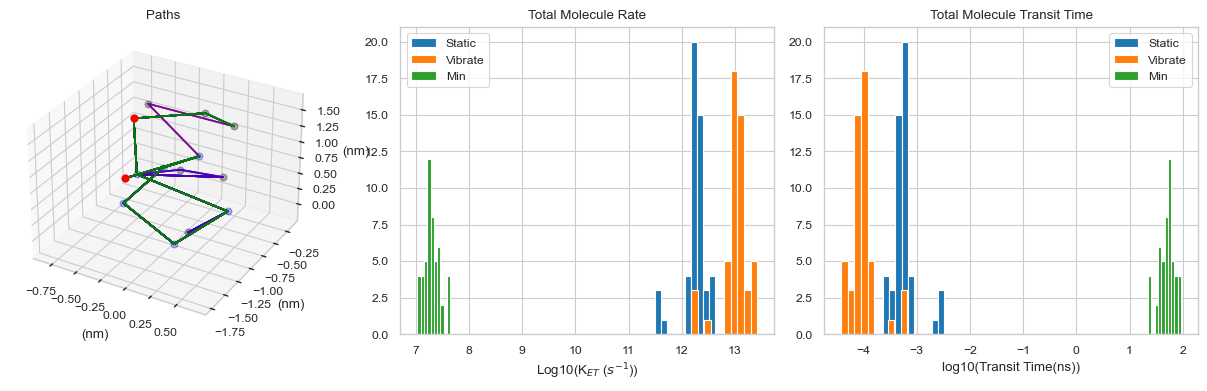

In [ ]:
#add information about rates to the network to allow for rate calculations
KMC_Protein. RateNetwork(G_vibrate)
KMC_Protein. RateNetwork(G_static)
KMC_Protein. RateNetwork(G_min)



shortestPaths_static=[]
shortestPaths_vibrate=[]
shortestPaths_min=[]

for startNode in [amino['aminoIndex'] for amino in injectionAminos]:
    for endNode in [amino['aminoIndex'] for amino in exitAminos]:
        shortestPaths_static.extend( KMC_Protein. CalculatePaths(G_static, activeAminos  ,startNode,endNode, weight='time'  ))
        shortestPaths_vibrate.extend(  KMC_Protein. CalculatePaths(G_vibrate , activeAminos ,startNode,endNode , weight='time' ))
        shortestPaths_min.extend(  KMC_Protein. CalculatePaths(G_min , activeAminos ,startNode,endNode , weight='time' ))

shortestPaths_static=KMC_Protein.sortPaths(shortestPaths_static, 'time')
shortestPaths_vibrate=KMC_Protein.sortPaths(shortestPaths_vibrate, 'time')
shortestPaths_min=KMC_Protein.sortPaths(shortestPaths_min, 'time')


KMC_Plotting. PlotGraphPaths(activeAminos,
                       shortestPaths_static,shortestPaths_vibrate,shortestPaths_min,
                       G_static, G_vibrate, G_min,
                       injectionAminos,exitAminos)


### Shortest Paths

Finding the shortest paths from our injection to exit sites allows the simulation to find the upper bounds of the transfer rate

In order to get statistics for the paths, Dijkstra and Bellman-Ford's methods are used to find the shortest paths with respect to the tranfer time between the nodes.  

Additional information is gathered by requiring the Dijkstra and Bellman-Ford methods to visit random nodes in the molecule, resulting in a statisical variation of the routes and possible times.

Once the times have been identified, the transit time for the molecule is calculated by summing the times for each jump and then taking an inverse.

The current is estimated from the rate, ignoring the contact resistance and other factors that may play a role in that calculations

Smoothing Energy Map


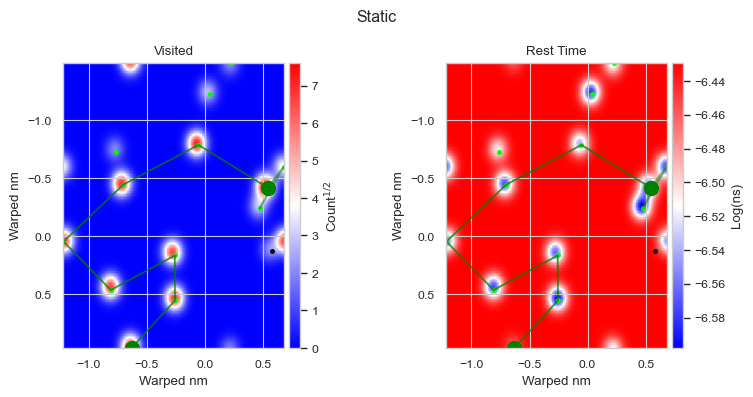

Smoothing Energy Map


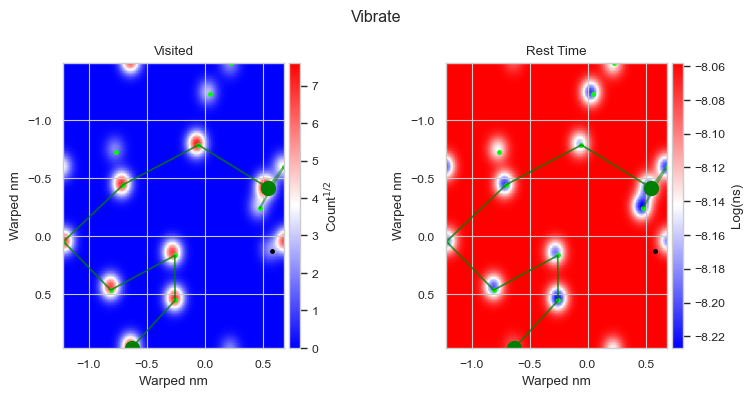

Smoothing Energy Map


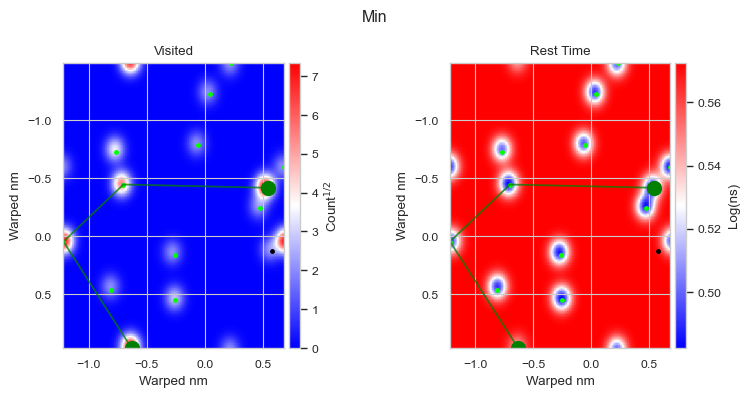

In [ ]:
KMC_Plotting.PlotPathMetrics(G_static, activeAminos,shortestPaths_static, "Static")
KMC_Plotting.PlotPathMetrics(G_vibrate, activeAminos,shortestPaths_vibrate, "Vibrate")
KMC_Plotting.PlotPathMetrics(G_min, activeAminos,shortestPaths_min, "Min")

del  shortestPaths_static, shortestPaths_vibrate, shortestPaths_min

## Rates Graphs

Once again the maniform transform is used to show the pathways through the system.  For the case of the rest time on the left, the tranfer rates inside the proteins show rapid exchange and diffusion within each protein, but very slow rates between the center.  The dots show the locations of each of the redox cofactors and the shade of green indicates that redox energy needed to oxidize that molecule.  Frequently, the path does jump through the harder to react Met residues, which may not be physical in an actual protein

The visited graph shows that some sites on the protein are virtually required for the graph to be able to reach the exit.  These sites are critical and are in the most mobile area of this construct, resulting in unstable transit times.

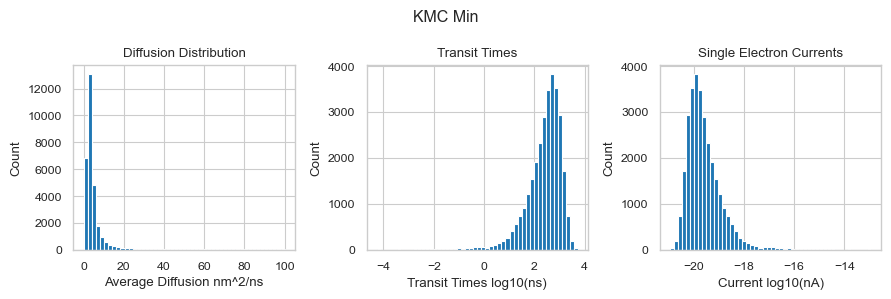

In [ ]:
##################################################################################
#################      Kinetic Monti Carlo            ############################
##################################################################################

successDwellTimes, dwellTimes, passes, electronTimes, diffusions=KMC_Protein.KMC(G_min, activeAminos, injectionAminos,exitAminos, numberElectrons=30000, maxIterations = 150000 )
KMC_Plotting.PlotKMC(activeAminos,successDwellTimes, dwellTimes, passes, electronTimes, diffusions,'KMC Min')



## Comparison with the published values

The overall rates compare favorable with those in the publication for this model. We still get what would be very low currents from the model, especially when the resistance of the contacts is also added to this system.  A better model would allow multiple electrons to exist inside the molecule and estimate the injection rate with added electrons.

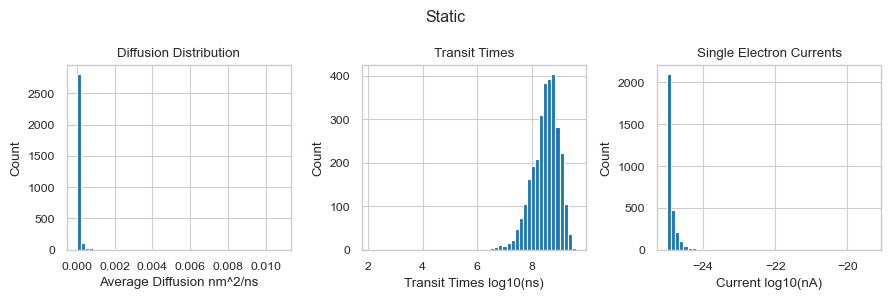

In [ ]:
successDwellTimes, dwellTimes, passes, electronTimes, diffusions=KMC_Protein. KMC(G_static, activeAminos, injectionAminos,exitAminos, numberElectrons=3000, maxIterations = 50000 )
KMC_Plotting. PlotKMC(activeAminos,successDwellTimes, dwellTimes, passes, electronTimes, diffusions,'Static')

##

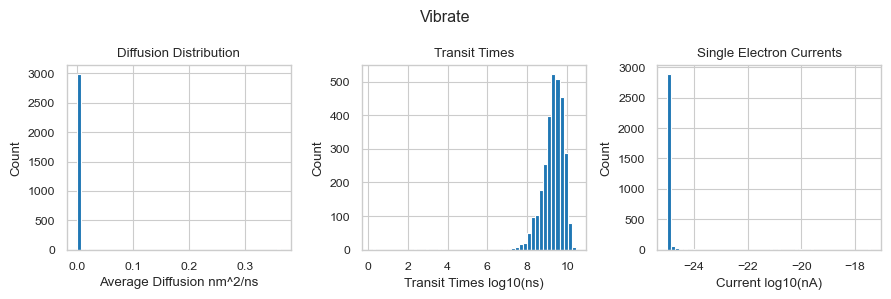

In [ ]:


successDwellTimes, dwellTimes, passes, electronTimes, diffusions=KMC_Protein.KMC(G_vibrate, activeAminos, injectionAminos,exitAminos, numberElectrons=3000, maxIterations = 50000 )
KMC_Plotting. PlotKMC(activeAminos,successDwellTimes, dwellTimes, passes, electronTimes, diffusions,'Vibrate')

